In [39]:
# NBVAL_IGNORE_OUTPUT
from secml.data.loader import CDataLoaderMNIST

import pickle
import numpy as np
from secml.array import CArray

from secml.ml.classifiers import CClassifierSVM
from secml.ml.peval.metrics import CMetricAccuracy
from secml.adv.attacks import CAttackPoisoningSVM

import matplotlib.pyplot as plt

In [ ]:
def multidimensional_descent(tr_data, k, num_itr):

    clf, Y_prev = None, None
    n, d = tr_data.X.shape
    Y = np.linalg.svd(np.random.randn(d, k))[0][:, :k]
    for i in range(num_itr):
        XY = CArray(tr_data.X.tondarray()@Y)
        clf = CClassifierSVM(C=10, kernel='linear')
        clf.fit(XY, tr_data.Y)
        # Compute x
        w = (2*tr_data.Y[clf._sv_idx]-1)*clf._alpha
        x = Y@(XY[clf._sv_idx, :].T.dot(w.T).tondarray())
        # if i%10 == 0: print(linear_reg_obj(A, b, x))
        x_unit = x/np.linalg.norm(x)
        U = np.linalg.svd(np.eye(d)-x_unit@x_unit.T)[0][:, :d-1]
        V = np.linalg.svd(np.random.randn(d-1, d-1))[0][:, :k-1]
        Y_prev = np.copy(Y)
        Y[:, :1], Y[:, 1:] = x_unit, U@V

    return x, clf, Y_prev

In [2]:
# MNIST dataset will be downloaded and cached if needed
loader = CDataLoaderMNIST()

In [46]:
random_state = 999

n_tr = 100  # Number of training set samples
n_val = 500  # Number of validation set samples
n_ts = 500  # Number of test set samples

# digits = (5, 9)
# digits = (3, 8)
digits = (2, 7)

tr_val = loader.load('training', digits=digits, num_samples=n_tr + n_val)
ts = loader.load('testing', digits=digits, num_samples=n_ts)

# Split in training and validation set
tr = tr_val[:n_tr, :]
val = tr_val[n_tr:, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
val.X /= 255
ts.X /= 255

## Experiments

In [47]:
# Bounds of the attack space. Can be set to `None` for unbounded
lb, ub = 0., 1.
# Should be chosen depending on the optimization problem
solver_params = {'eta': 0.25, 'eta_min': 2.0, 'eta_max': None, 'max_iter': 100, 'eps': 1e-6}
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

n_ps_points_arr = [10, 20, 30, 40, 50]
k_arr = [20, 40, 60, 80]
# n_ps_points_arr = [10, 20, 30]
# k_arr = [20, 40]

num_itr, num_trials = 10, 10

metric = CMetricAccuracy()

acc_full_mat = np.zeros(len(n_ps_points_arr))
acc_k_mat = np.zeros((len(n_ps_points_arr), len(k_arr), num_trials))

# Train an SVM over the clean data and compute it's accuracy
clf = CClassifierSVM(C=10, kernel='linear')
clf.fit(tr.X, tr.Y)
y_pred = clf.predict(ts.X)
acc_clean = 100*metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# print("Accuracy on test set: {:.2%}".format(acc))

for in_ps, n_ps_points in enumerate(n_ps_points_arr):

    # Generate a poisoned dataset with n_ps_points poisoned points
    pois_attack.n_points = n_ps_points
    pois_y_pred, _, pois_points_ds, _ = pois_attack.run(ts.X, ts.Y)
    pois_tr = tr.deepcopy().append(pois_points_ds)

    # Calculate the accuracy for training an SVM in full dimension
    pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)
    # print("Accuracy after attack on test set: {:.2%}".format(pois_acc))
    acc_full_mat[in_ps] = 100*pois_acc

    # Calculate the accuracies for training SVMs using our algorithm
    for ik, k in enumerate(k_arr):
        for nt in range(num_trials):
            x_k, clf_k, Y = multidimensional_descent(pois_tr, k, num_itr)
            XtY = CArray(ts.X.tondarray()@Y)
            y_pred = clf_k.predict(XtY)
            acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
            # print("k = ", k)
            # print("Accuracy: {:.2%}".format(acc))
            acc_k_mat[in_ps, ik, nt] = 100*acc

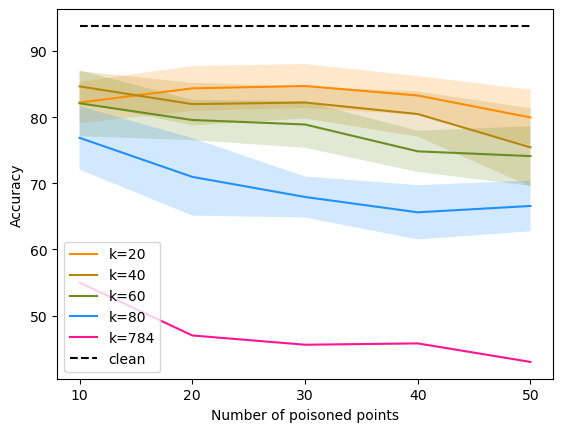

In [48]:
# Plotting code
colors = ['darkorange', 'darkgoldenrod', 'olivedrab', 'dodgerblue', 'deeppink', 'crimson']

t = np.arange(len(n_ps_points_arr))
fig, ax = plt.subplots(1)
for ik, k in enumerate(k_arr):
    mu = np.mean(acc_k_mat[:, ik, :], axis=-1)
    sigma = np.std(acc_k_mat[:, ik, :], axis=-1)
    ax.plot(t, mu, label=f"k={k}", color=colors[ik])
    ax.fill_between(t, mu+sigma, mu-sigma, facecolor=colors[ik], alpha=0.2)
ax.plot(t, acc_full_mat, label=f'k={tr.X.shape[1]}', color=colors[-2])
ax.plot(t, acc_clean*np.ones(len(t)), '--', label='clean', color='black')
ax.set_xticks(ticks=t, labels=n_ps_points_arr)
ax.set_xlabel("Number of poisoned points")
ax.set_ylabel("Accuracy")
ax.legend()
plt.savefig(f'svm_{digits[0]}_{digits[1]}.png', bbox_inches='tight')
plt.show()

In [ ]:
picklen.dump()